In [1]:
import qiskit_ibm_runtime
print(qiskit_ibm_runtime.__version__)

0.40.1


In [2]:
import qiskit_aer
print(qiskit_aer.__version__)

0.17.1


In [3]:
from qiskit_aer import Aer
print(Aer.backends())

[AerSimulator('aer_simulator'), AerSimulator('aer_simulator_statevector'), AerSimulator('aer_simulator_density_matrix'), AerSimulator('aer_simulator_stabilizer'), AerSimulator('aer_simulator_matrix_product_state'), AerSimulator('aer_simulator_extended_stabilizer'), AerSimulator('aer_simulator_unitary'), AerSimulator('aer_simulator_superop'), QasmSimulator('qasm_simulator'), StatevectorSimulator('statevector_simulator'), UnitarySimulator('unitary_simulator')]


In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save your IBM Cloud-based instance (this format is correct for cloud channel)
QiskitRuntimeService.save_account(
    token="rJVwqI6omYOBPtOSg78_XoHusk6bz8sQ1nf5vDsH0msq",
    instance="quantum-img-proc",  # Use only the instance name
    channel="ibm_cloud",
    overwrite=True
)

# Load the account using the IBM Cloud channel
service = QiskitRuntimeService(channel="ibm_cloud")
print(service.backends())

[<IBMBackend('ibm_torino')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_brisbane')>]


Image (2x2 Grayscale):
[[  0  85]
 [170 255]]


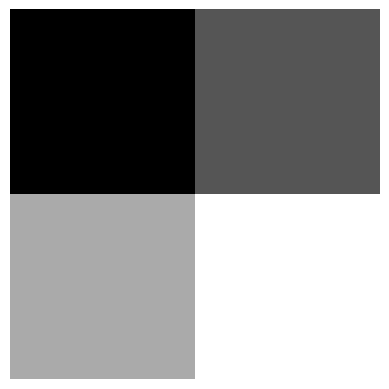

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Create a specific 2x2 image with given pixel values
image = np.array([[0, 85],
                  [170, 255]], dtype=np.uint8)

# Print image values
print("Image (2x2 Grayscale):")
print(image)

# Plot the image
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [6]:
import numpy as np

# Intensity values
image = np.array([[0, 85], [170, 255]])

# Flatten in row-major order
pixels = image.flatten()
binary_representations = [format(pix, '08b') for pix in pixels]

# Generate position states (2 qubits for 2x2 image)
positions = ['00', '01', '10', '11']

# Print NEQR states
print("|I⟩ = 1/2 * (")
for i in range(4):
    print(f"  |{binary_representations[i]}⟩ ⊗ |{positions[i]}⟩")
print(")")


|I⟩ = 1/2 * (
  |00000000⟩ ⊗ |00⟩
  |01010101⟩ ⊗ |01⟩
  |10101010⟩ ⊗ |10⟩
  |11111111⟩ ⊗ |11⟩
)


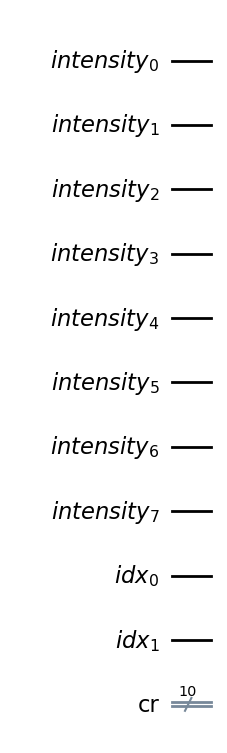

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Quantum registers
idx = QuantumRegister(2, 'idx')               # 2 qubits for position
intensity = QuantumRegister(8, 'intensity')   # 8 qubits for grayscale intensity
cr = ClassicalRegister(10, 'cr')              # Classical register for full measurement

# Create the quantum circuit
qc_image = QuantumCircuit(intensity, idx, cr)

# Display circuit (optional)
qc_image.draw('mpl')  # or use print(qc_image) for text version


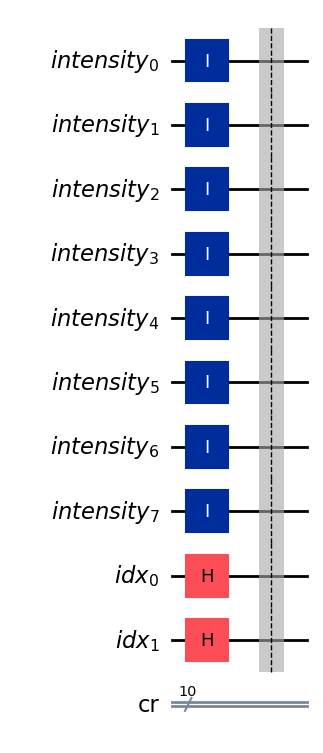

In [4]:
# Optional: Add Identity gates to the intensity qubits
for i in range(intensity.size):
    qc_image.id(intensity[i])  # Use .id() instead of .i()

# Add Hadamard gates to the pixel position qubits
for q in idx:
    qc_image.h(q)

# Add a barrier for readability
qc_image.barrier()

# Draw the circuit (optional visualization)
qc_image.draw('mpl')  # Use 'mpl' if using a Jupyter notebook


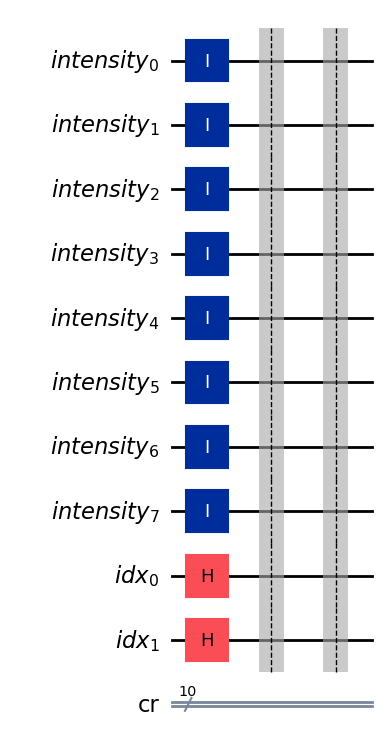

In [5]:
# First pixel (position |00⟩), value = 0 (binary 00000000)
# No need to apply any X gate to intensity — all bits are already |0⟩, so we just leave them as is

# Barrier after encoding first pixel (for clarity)
qc_image.barrier()

# Visualize circuit
qc_image.draw('mpl')


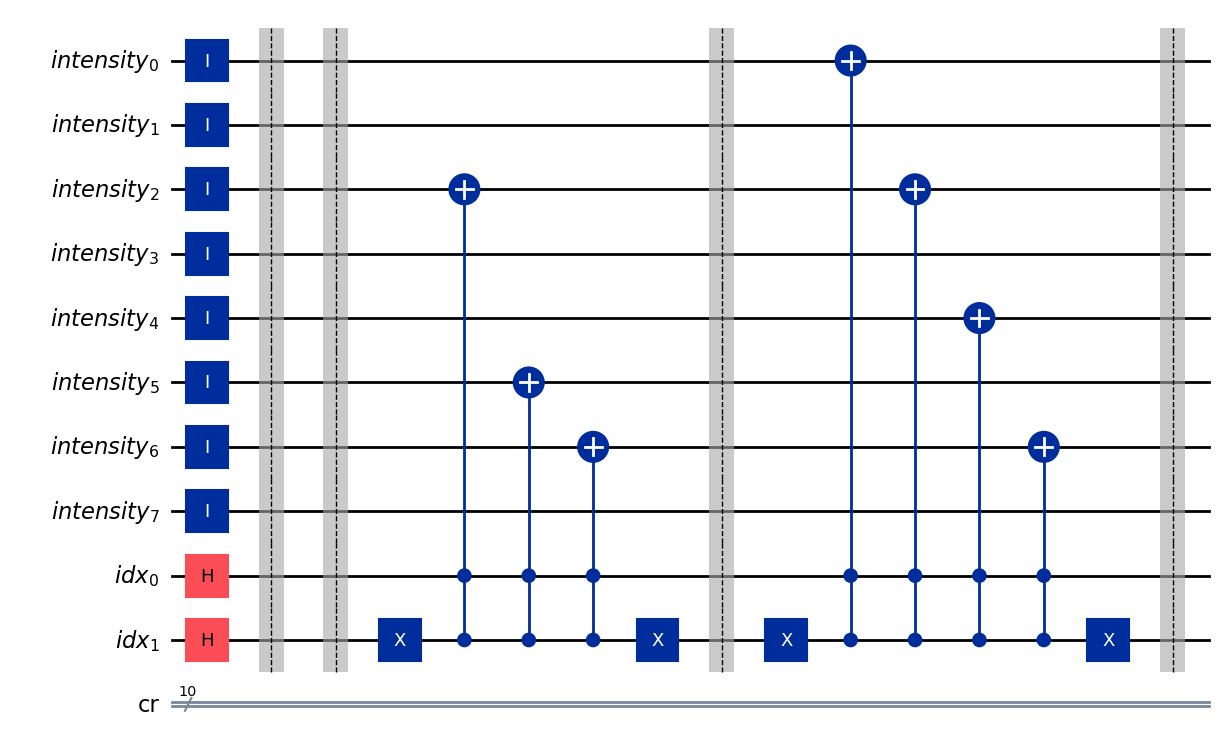

In [7]:
# Pixel 2: Intensity = 01100100, Position = |01⟩
value01 = '01010101'

# Add X gate to set position qubits to |01⟩ (i.e., idx[1] = 1, idx[0] = 0)
qc_image.x(idx[1])

# Apply CCX (Toffoli) gates: control on idx[1] and idx[0] (|01⟩), target is intensity qubit
for bit_index, px_bit in enumerate(value01[::-1]):  # reverse to match MSB–LSB
    if px_bit == '1':
        qc_image.ccx(idx[1], idx[0], intensity[bit_index])

# Reset idx[1] back to |0⟩
qc_image.x(idx[1])

# Barrier for clarity
qc_image.barrier()

# Draw circuit
qc_image.draw('mpl')


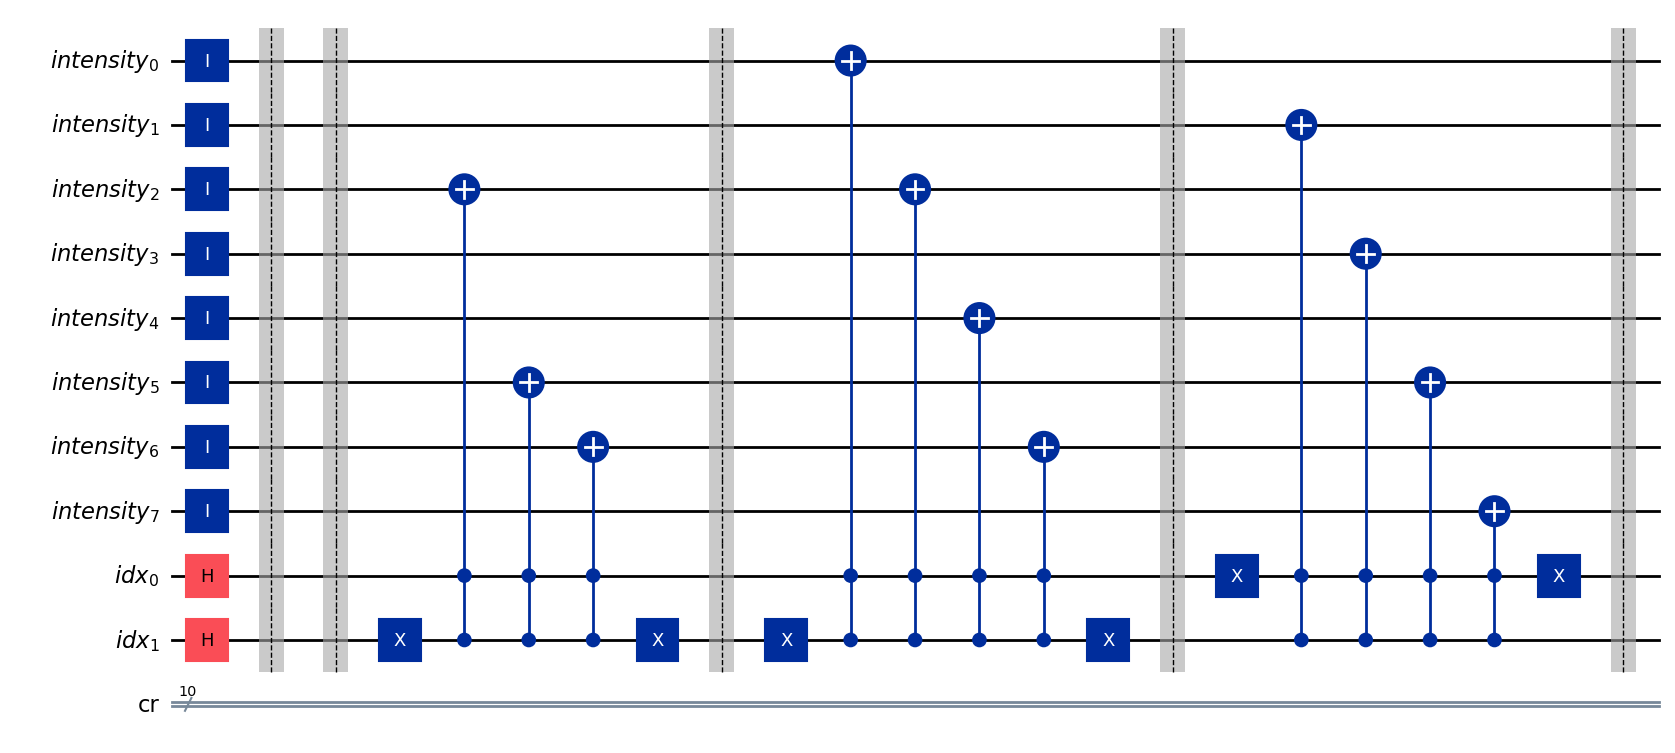

In [8]:
# Pixel 3: Intensity = 11001000, Position = |10⟩
value10 = '10101010'

# Set position to |10⟩ => idx[1]=0, idx[0]=1 => apply X to idx[0]
qc_image.x(idx[0])

# Apply CCX gates with controls: idx[1]=0, idx[0]=1
# This encodes only when pixel position is |10⟩
for bit_index, px_bit in enumerate(value10[::-1]):  # reverse to match bit order
    if px_bit == '1':
        qc_image.ccx(idx[1], idx[0], intensity[bit_index])

# Reset idx[0] back to |0⟩
qc_image.x(idx[0])

# Add barrier
qc_image.barrier()

# Draw circuit
qc_image.draw('mpl')


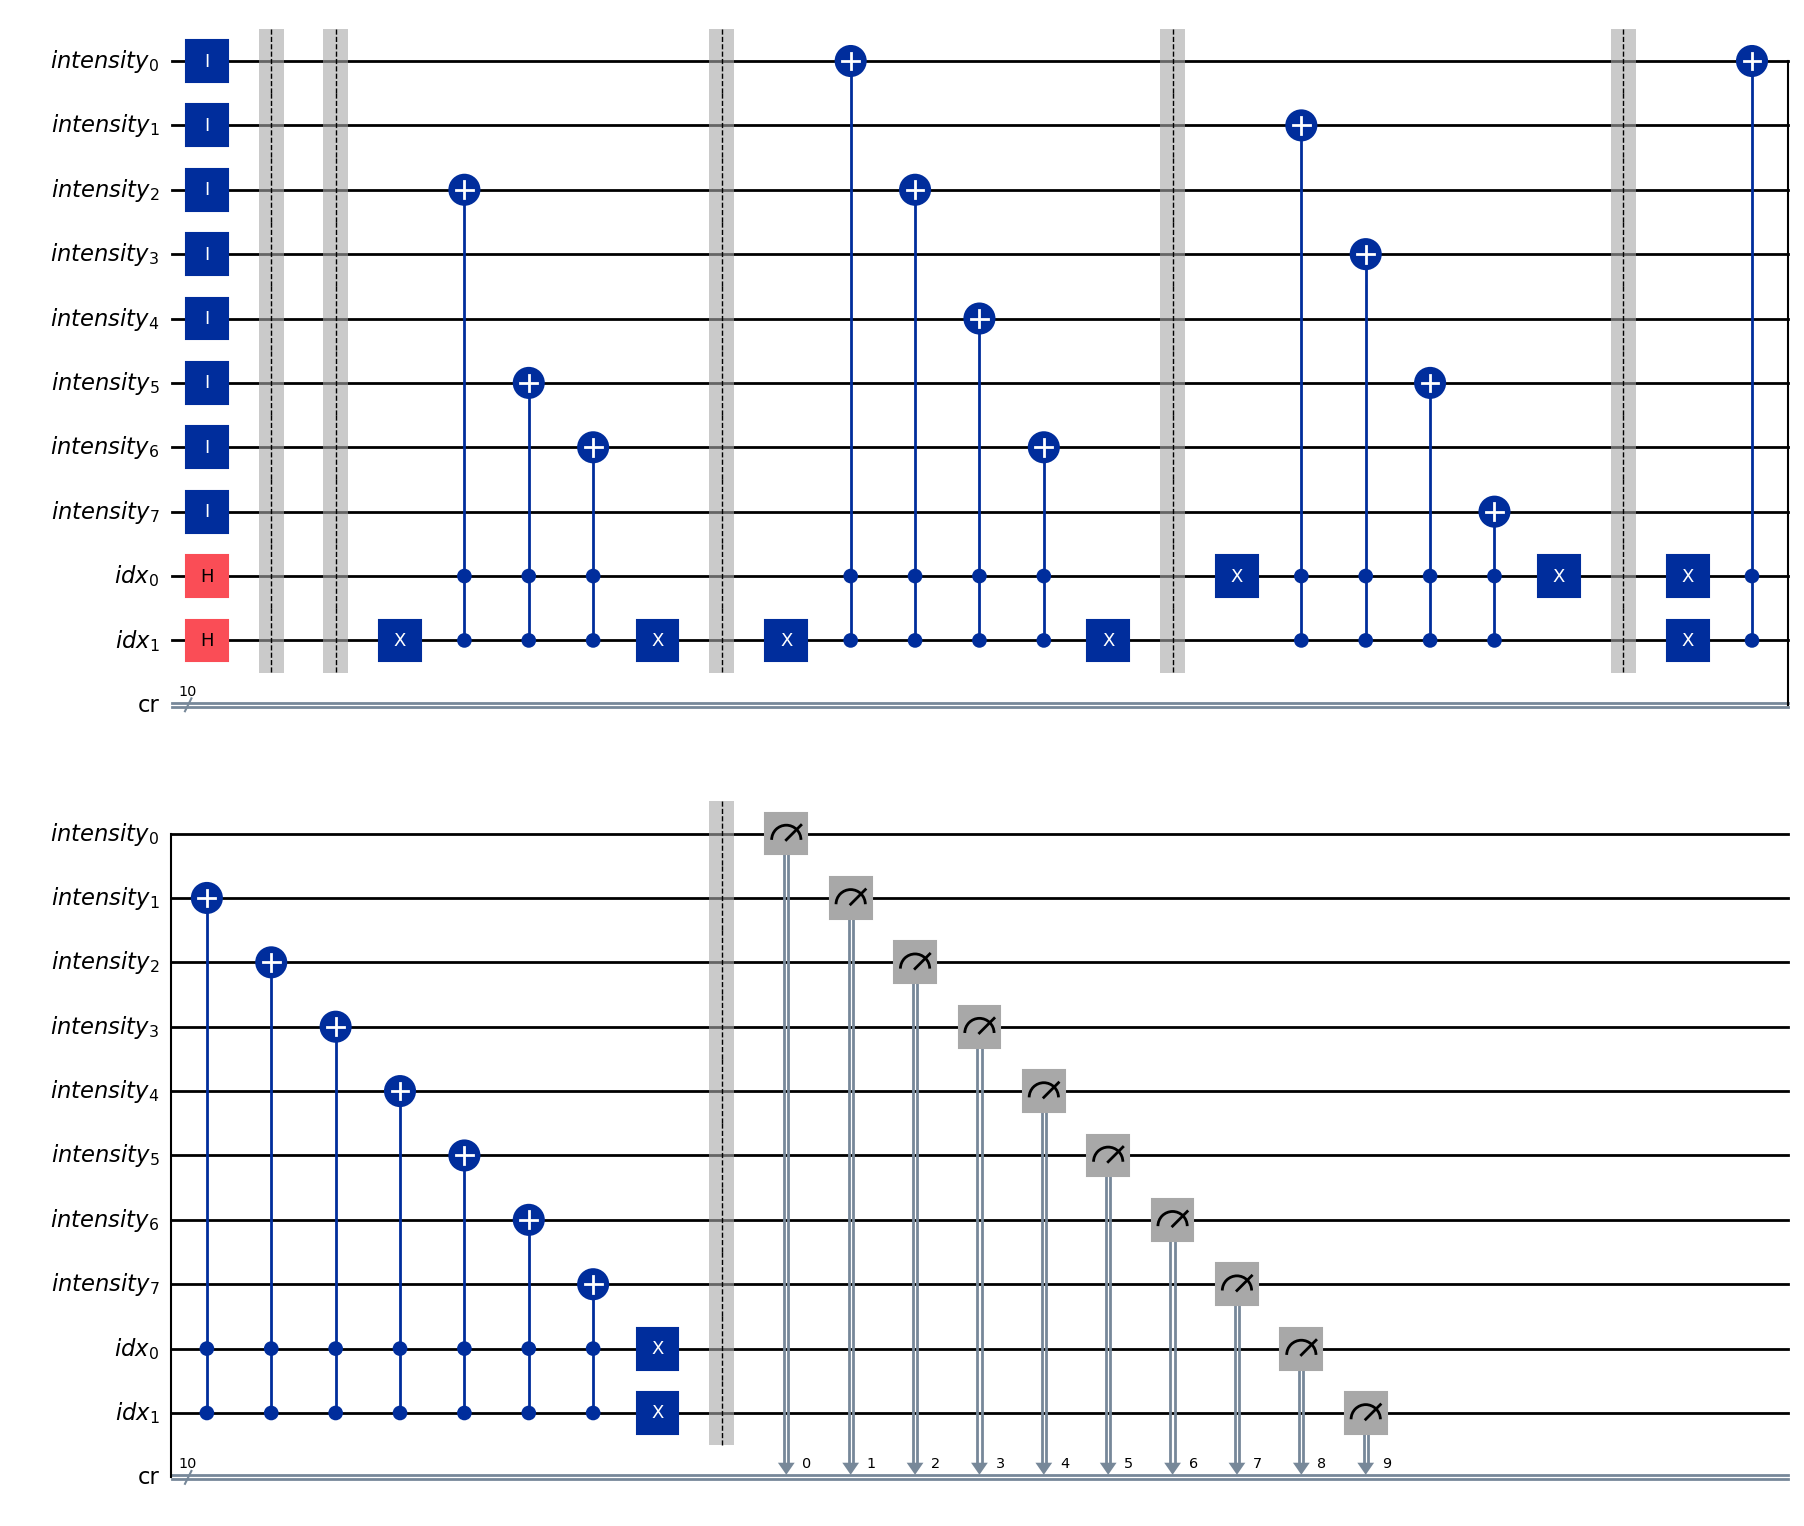

In [9]:
# Pixel 4: Intensity = 11111111, Position = |11⟩
value11 = '11111111'

# Set position to |11⟩ => apply X to idx[0] and idx[1]
qc_image.x(idx[0])
qc_image.x(idx[1])

# Apply CCX (Toffoli) gates to encode intensity bits
# Controls: idx[1] and idx[0]; Target: each intensity qubit
for bit_index, px_bit in enumerate(value11[::-1]):  # reverse for bit ordering
    if px_bit == '1':
        qc_image.ccx(idx[1], idx[0], intensity[bit_index])

# Reset the pixel position back to |00⟩
qc_image.x(idx[0])
qc_image.x(idx[1])

# Add barrier
qc_image.barrier()

# Add measurements
qc_image.measure(intensity[:] + idx[:], cr[:])  # measure all 10 qubits

# Draw final circuit
qc_image.draw('mpl')


In [10]:
print('Circuit dimensions')
print('Circuit depth: ', qc_image.decompose().depth())
print('Circuit size: ', qc_image.decompose().size())

qc_image.decompose().count_ops()


Circuit dimensions
Circuit depth:  200
Circuit size:  315


OrderedDict([('cx', 114),
             ('t', 76),
             ('tdg', 57),
             ('h', 38),
             ('u', 12),
             ('measure', 10),
             ('id', 8),
             ('barrier', 6)])

Encoded: 00 = 0
Encoded: 01 = 01100100
Encoded: 10 = 11001000
Encoded: 11 = 1

{'1100000000': 2017, '0011111111': 1998, '1010101010': 2083, '0100110001': 2094}


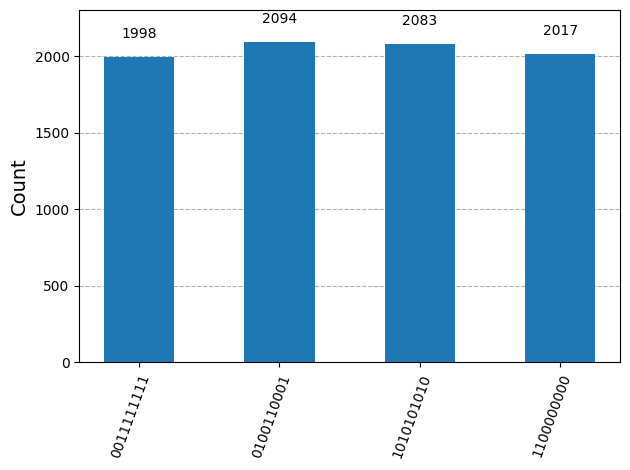

In [12]:
from qiskit_aer import Aer
from qiskit import transpile
from qiskit.visualization import plot_histogram

# Get the Aer simulator backend
aer_sim = Aer.get_backend('aer_simulator')

# Transpile the circuit for the simulator
t_qc_image = transpile(qc_image, aer_sim)

# Run the circuit directly without using assemble
job_neqr = aer_sim.run(t_qc_image, shots=8192)

# Get results
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()

# Display the result
print('Encoded: 00 = 0')
print('Encoded: 01 = 01100100')
print('Encoded: 10 = 11001000')
print('Encoded: 11 = 1\n')
print(counts_neqr)

# Plot histogram
plot_histogram(counts_neqr)
